In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path  # Needed for point-in-polygon checks


In [3]:
# --- Voronoi helpers (keep your existing functions) ---
def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [4]:
#run this cell for new district lines

# --- Simulation parameters ---
WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8 #congressional districts 
NUM_DOTS = 1000  # Number of population dots
COLORS = ['red', 'blue', 'green']

# --- Generate random district centers and Voronoi (run once) ---
points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT

vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)




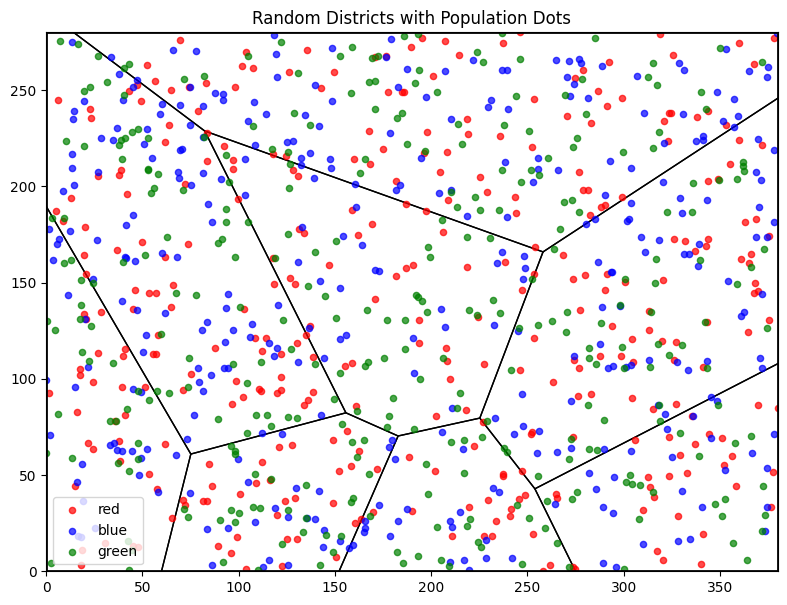

District 1: {'red': 32, 'blue': 23, 'green': 31}
District 2: {'red': 21, 'blue': 22, 'green': 23}
District 3: {'red': 76, 'blue': 85, 'green': 70}
District 4: {'red': 29, 'blue': 28, 'green': 28}
District 5: {'red': 56, 'blue': 59, 'green': 49}
District 6: {'red': 57, 'blue': 70, 'green': 57}
District 7: {'red': 28, 'blue': 25, 'green': 23}
District 8: {'red': 39, 'blue': 28, 'green': 41}


In [5]:
#run this cell for new population ditribution 

# --- Generate random population dots ---
dots_x = np.random.rand(NUM_DOTS) * WIDTH
dots_y = np.random.rand(NUM_DOTS) * HEIGHT
dots_colors = np.random.choice(COLORS, NUM_DOTS)

# --- Count dots per district ---
district_counts = []  # List of dictionaries for each district

fig, ax = plt.subplots(figsize=(10, 7))

for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_counts.append({'red':0, 'blue':0, 'purple':0})
        continue
    polygon = sort_polygon(polygon)
    
    # Draw the district boundary
    ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)
    
    # Create a Path object for point-in-polygon testing
    poly_path = Path(polygon)
    mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))
    
    # Count dots by color inside this district
    counts = {color: 0 for color in COLORS}
    for color, inside in zip(dots_colors, mask):
        if inside:
            counts[color] += 1
    district_counts.append(counts)


# --- Draw the population dots ---
for color in COLORS:
    ax.scatter(dots_x[dots_colors==color], dots_y[dots_colors==color], 
               c=color, label=color, s=20, alpha=0.7)


# Colorado boundary
ax.plot([0, WIDTH, WIDTH, 0, 0], [0, 0, HEIGHT, HEIGHT, 0], color='black', linewidth=2)

ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Random Districts with Population Dots')
ax.legend()
plt.show()

# --- Print out counts for each district ---
for i, counts in enumerate(district_counts):
    print(f"District {i+1}: {counts}")


Find which party wins in each district

In [6]:
# --- Print dominant color per district ---
for i, counts in enumerate(district_counts):
    dominant_color = max(counts, key=counts.get)
    print(f"District {i+1}: dominant color = {dominant_color}")



District 1: dominant color = red
District 2: dominant color = green
District 3: dominant color = blue
District 4: dominant color = red
District 5: dominant color = blue
District 6: dominant color = blue
District 7: dominant color = red
District 8: dominant color = green


Just below this is victoria attempt at fixing district lines and running simulation 

code box that computes proportional representation

In [7]:
# --- PROPORTIONAL REPRESENTATION (Largest Remainder Method) ---

# INPUTS 
# COLORS         -> list of parties
# district_counts -> list of dicts, one per district:
# NUM_SEATS      -> total number of seats to allocate ( 8: same as number of districts)

NUM_SEATS = NUM_DISTRICTS

# --- Compute statewide vote totals ---
# Create an empty dictionary to hold total votes for each party
statewide_votes = {color: 0 for color in COLORS}

# Sum votes across all districts
for district in district_counts:
    for color in COLORS:
        statewide_votes[color] += district[color]

# Total number of votes cast statewide
total_votes = sum(statewide_votes.values())

# --- Compute each party's exact seat entitlement (proportipnal representation) ---

exact_seats = {} # This dictionary will store the exact (fractional) number of seats each party deserves based on vote share

for color in COLORS:
    vote_share = statewide_votes[color] / total_votes
    exact_seats[color] = vote_share * NUM_SEATS

# --- Assign the guaranteed whole-number seats ---

# Each party immediately receives the integer part of its entitlement
allocated_seats = {
    color: int(exact_seats[color])
    for color in COLORS
}

# Count how many seats have been assigned so far
seats_assigned = sum(allocated_seats.values())

# --- Compute remaining seats to distribute ---
# These are the seats left after the integer allocation
remaining_seats = NUM_SEATS - seats_assigned


# --- Rank parties by their fractional remainders ---

# The remainder is the fractional part of the exact seat entitlement
remainders = {
    color: exact_seats[color] - allocated_seats[color]
    for color in COLORS
}

# Sort parties by largest remainder 
sorted_by_remainder = sorted(
    COLORS,
    key=lambda c: remainders[c],
    reverse=True
)

# --- Distribute remaining seats ---
# Give one extra seat to each party with the largest remainder
# until all remaining seats are assigned
for i in range(remaining_seats):
    party = sorted_by_remainder[i]
    allocated_seats[party] += 1


print("\n--- PROPORTIONAL REPRESENTATION ---")
for color in COLORS:
    print(
        f"{color.capitalize():7s} | "
        f"State Wide Votes: {statewide_votes[color]:6d} | "
        f"State Votes/Total Votes: {statewide_votes[color] / total_votes:.2%} | "
        f"Seats: {allocated_seats[color]}|" 
        f"total votes: {total_votes} "
    )



--- PROPORTIONAL REPRESENTATION ---
Red     | State Wide Votes:    338 | State Votes/Total Votes: 33.80% | Seats: 3|total votes: 1000 
Blue    | State Wide Votes:    340 | State Votes/Total Votes: 34.00% | Seats: 3|total votes: 1000 
Green   | State Wide Votes:    322 | State Votes/Total Votes: 32.20% | Seats: 2|total votes: 1000 


code box that computes partisan measure

In [8]:
for value in district_counts[0].values():
    print(value)



32
23
31


code box that computes efficiency gap

Efficiency Gap =
    (Wasted votes of Party A − Wasted votes of Party B)
    ---------------------------------------------------
                  Total votes


testing local access
